# Store Sales Forecasting with TensorFlow

Goal -  The project involves making sales predictions for various stores of a large retail corporation, based on past sales of these stores, using TensorFlow

The dataset comes in three CSV files: weekly_sales.csv, features.csv, and stores.csv


## Preliminary Data Analysis
### The Dataset

In [1]:
import pandas as pd
train_df = pd.read_csv('./storeSalesForecasting/train.csv')
print(train_df)

        Store  Dept        Date  Weekly_Sales  IsHoliday
0           1     1  2010-02-05      24924.50      False
1           1     1  2010-02-12      46039.49       True
2           1     1  2010-02-19      41595.55      False
3           1     1  2010-02-26      19403.54      False
4           1     1  2010-03-05      21827.90      False
...       ...   ...         ...           ...        ...
421565     45    98  2012-09-28        508.37      False
421566     45    98  2012-10-05        628.10      False
421567     45    98  2012-10-12       1061.02      False
421568     45    98  2012-10-19        760.01      False
421569     45    98  2012-10-26       1076.80      False

[421570 rows x 5 columns]


In [2]:
def read_dataframes():
    train_df = pd.read_csv('./storeSalesForecasting/train.csv')
    features_df = pd.read_csv('./storeSalesForecasting/features.csv')
    stores_df = pd.read_csv('./storeSalesForecasting/stores.csv')
    return (train_df, features_df, stores_df)

(train_df, features_df, stores_df) = read_dataframes()

In [3]:
general_features = features_df.columns

print(general_features)
print('General Features: {}\n'.format(general_features.tolist()))

store_features = stores_df.columns
print('Store Features: {}'.format(store_features.tolist()))

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')
General Features: ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']

Store Features: ['Store', 'Type', 'Size']


In [4]:
merged_features = features_df.merge(stores_df, on='Store')

print(merged_features)

      Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0         1  2010-02-05        42.31       2.572        NaN        NaN   
1         1  2010-02-12        38.51       2.548        NaN        NaN   
2         1  2010-02-19        39.93       2.514        NaN        NaN   
3         1  2010-02-26        46.63       2.561        NaN        NaN   
4         1  2010-03-05        46.50       2.625        NaN        NaN   
...     ...         ...          ...         ...        ...        ...   
8185     45  2013-06-28        76.05       3.639    4842.29     975.03   
8186     45  2013-07-05        77.50       3.614    9090.48    2268.58   
8187     45  2013-07-12        79.37       3.614    3789.94    1827.31   
8188     45  2013-07-19        82.84       3.737    2961.49    1047.07   
8189     45  2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  \
0           NaN        NaN       

### Missing Features

In [5]:
na_values = pd.isna(merged_features) # Boolean DataFrame
na_features = na_values.any() # Boolean Series
print(na_features)

Store           False
Date            False
Temperature     False
Fuel_Price      False
MarkDown1        True
MarkDown2        True
MarkDown3        True
MarkDown4        True
MarkDown5        True
CPI              True
Unemployment     True
IsHoliday       False
Type            False
Size            False
dtype: bool


### Dropping Features

In [6]:
print(f"Total = {len(na_values)}")
print(f"MarkDown1 = {sum(na_values['MarkDown1'])}")
print(f"MarkDown2 = {sum(na_values['MarkDown2'])}")
print(f"MarkDown3 = {sum(na_values['MarkDown3'])}")
print(f"MarkDown4 = {sum(na_values['MarkDown4'])}")
print(f"MarkDown5 = {sum(na_values['MarkDown5'])}")
print(f"CPI = {sum(na_values['CPI'])}")
print(f"Unemployment = {sum(na_values['Unemployment'])}")

Total = 8190
MarkDown1 = 4158
MarkDown2 = 5269
MarkDown3 = 4577
MarkDown4 = 4726
MarkDown5 = 4140
CPI = 585
Unemployment = 585


In [7]:
# Drop MarkDown columns, while drop missing CPI and Unemployment missing values
markdowns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', ]
merged_features = merged_features.drop(columns=markdowns)
merged_features.columns.tolist()

['Store',
 'Date',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'IsHoliday',
 'Type',
 'Size']

### Filling in Data
- find missing CPI and Unemployment values
- fill it with previous row values

In [8]:
merged_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   CPI           7605 non-null   float64
 5   Unemployment  7605 non-null   float64
 6   IsHoliday     8190 non-null   bool   
 7   Type          8190 non-null   object 
 8   Size          8190 non-null   int64  
dtypes: bool(1), float64(4), int64(2), object(2)
memory usage: 583.9+ KB


In [9]:
# merged_features[['CPI', 'Unemployment']]
import numpy as np

na_cpi_int = na_values['CPI'].astype(int)
na_indexes_cpi = na_cpi_int.to_numpy().nonzero()[0]
na_une_int = na_values['Unemployment'].astype(int)
na_indexes_une = na_une_int.to_numpy().nonzero()[0]

print(np.array_equal(na_indexes_cpi, na_indexes_une)) # Same index for both fields

True


In [10]:
na_indexes = na_indexes_cpi
na_rows = merged_features.iloc[na_indexes]
print(na_rows['Date'].unique()) # missing value weeks
print(merged_features['Date'].unique()[-13:]) # last 13 weeks
print(na_rows.groupby('Store').count()['Date'].unique())

['2013-05-03' '2013-05-10' '2013-05-17' '2013-05-24' '2013-05-31'
 '2013-06-07' '2013-06-14' '2013-06-21' '2013-06-28' '2013-07-05'
 '2013-07-12' '2013-07-19' '2013-07-26']
['2013-05-03' '2013-05-10' '2013-05-17' '2013-05-24' '2013-05-31'
 '2013-06-07' '2013-06-14' '2013-06-21' '2013-06-28' '2013-07-05'
 '2013-07-12' '2013-07-19' '2013-07-26']
[13]


In [11]:
# na_rows
# merged_features
# na_rows.groupby('Store').count()['Date'].unique() # 13
# merged_features.groupby('Store').count()['Date'].unique() # 182
# merged_features['Date'].unique()

# Fill in the values
# merged_features
print(na_indexes[0])  # first missing value row index
# print(na_indexes)
print()

first_missing_row = merged_features.iloc[169]
print(first_missing_row[['Date','CPI','Unemployment']])
print()

final_val_row = merged_features.iloc[168]
print(final_val_row[['Date','CPI','Unemployment']])
print()

cpi_final_val = merged_features.at[168, 'CPI']
une_final_val = merged_features.at[168, 'Unemployment']
merged_features.at[169, 'CPI'] = cpi_final_val
merged_features.at[169, 'Unemployment'] = une_final_val

new_row = merged_features.iloc[169]
print(new_row[['Date','CPI','Unemployment']])
print()

169

Date            2013-05-03
CPI                    NaN
Unemployment           NaN
Name: 169, dtype: object

Date            2013-04-26
CPI              225.17016
Unemployment         6.314
Name: 168, dtype: object

Date            2013-05-03
CPI              225.17016
Unemployment         6.314
Name: 169, dtype: object



In [12]:
def impute_data(merged_features, na_indexes_cpi, na_indexes_une):
    for i in na_indexes_cpi:
        merged_features.at[i, 'CPI'] = merged_features.at[i-1, 'CPI']
    for i in na_indexes_une:
        merged_features.at[i, 'Unemployment'] = merged_features.at[i-1, 'Unemployment']
        
impute_data(merged_features, na_indexes_cpi, na_indexes_une)
na_values2 = pd.isna(merged_features) # Boolean DataFrame
na_features2 = na_values2.any() # Boolean Series
print(na_features2)

Store           False
Date            False
Temperature     False
Fuel_Price      False
CPI             False
Unemployment    False
IsHoliday       False
Type            False
Size            False
dtype: bool


### Merging Data

In [13]:
print(train_df.columns.tolist())
print(merged_features.columns.tolist())

['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
['Store', 'Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Type', 'Size']


In [14]:
# Common columns - ['Store', 'Date', 'IsHoliday']
features = ['Store', 'Date', 'IsHoliday']
final_dataset = train_df.merge(merged_features, on=features)
final_dataset
# print(train_df['Store'].unique())
# print(train_df['Date'].unique())# Less dates
# print(train_df['IsHoliday'].unique())

# print(merged_features['Store'].unique())
# print(merged_features['Date'].unique()) # More dates
# print(merged_features['IsHoliday'].unique())

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,192.308899,8.667,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,192.308899,8.667,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,192.308899,8.667,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,192.308899,8.667,B,118221


In [15]:
# 'Date' is not used in ML model, so drop it
final_dataset = final_dataset.drop(columns=['Date'])

### Categorical Data

In [16]:
final_dataset.describe(include='all')

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
count,421570.000000,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570,421570.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,A,NaN
freq,NaN,NaN,NaN,391909,NaN,NaN,NaN,NaN,215478,NaN
mean,22.200546,44.260317,15981.258123,NaN,60.090059,3.361027,171.201947,7.960289,NaN,136727.915739
std,12.785297,30.492054,22711.183519,NaN,18.447931,0.458515,39.159276,1.863296,NaN,60980.583328
min,1.000000,1.000000,-4988.940000,NaN,-2.060000,2.472000,126.064000,3.879000,NaN,34875.000000
25%,11.000000,18.000000,2079.650000,NaN,46.680000,2.933000,132.022667,6.891000,NaN,93638.000000
50%,22.000000,37.000000,7612.030000,NaN,62.090000,3.452000,182.318780,7.866000,NaN,140167.000000
75%,33.000000,74.000000,20205.852500,NaN,74.280000,3.738000,212.416993,8.572000,NaN,202505.000000


In [17]:
print(final_dataset['Type'].unique())
print(final_dataset['Dept'].unique())

['A' 'B' 'C']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 79 80 81 82 83 85 87 90 91 92 93 94 95 97
 98 78 96 99 77 39 50 43 65]


In [18]:
# Cast IsHoliday to type int - features must be integer, float, or string
final_dataset = final_dataset.astype({"IsHoliday": int})
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  int64  
 4   Temperature   421570 non-null  float64
 5   Fuel_Price    421570 non-null  float64
 6   CPI           421570 non-null  float64
 7   Unemployment  421570 non-null  float64
 8   Type          421570 non-null  object 
 9   Size          421570 non-null  int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 35.4+ MB


### 1. Plot data

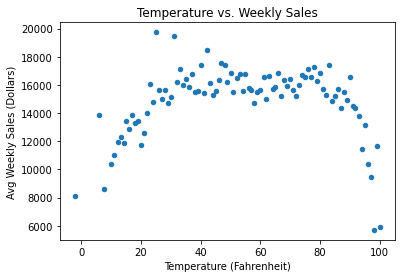

In [19]:
import matplotlib.pyplot as plt

plot_df = final_dataset[['Weekly_Sales', 'Temperature']]
rounded_temp = plot_df['Temperature'].round()
plot_df = plot_df.groupby(rounded_temp).mean()
plot_df.plot.scatter(x='Temperature', y='Weekly_Sales')
plt.title('Temperature vs. Weekly Sales')
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Avg Weekly Sales (Dollars)')
plt.show()

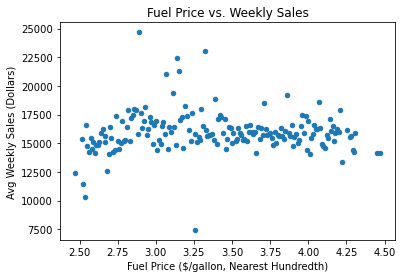

In [20]:
plot_df = final_dataset[['Weekly_Sales', 'Fuel_Price']]
rounded_temp = plot_df['Fuel_Price'].round(2)
plot_df = plot_df.groupby(rounded_temp).mean()
plot_df.plot.scatter(x='Fuel_Price', y='Weekly_Sales')
plt.title('Fuel Price vs. Weekly Sales')
plt.xlabel('Fuel Price ($/gallon, Nearest Hundredth)')
plt.ylabel('Avg Weekly Sales (Dollars)')
plt.show()
# plot_df['Fuel_Price'].round(1).unique()

      Weekly_Sales
Type              
A     20099.568043
B     12237.075977
C      9519.532538


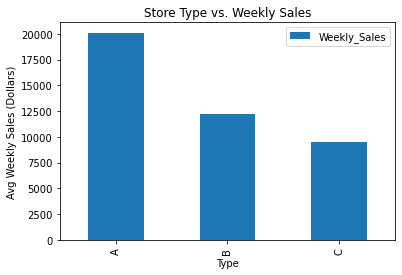

In [21]:
plot_df = final_dataset[['Weekly_Sales', 'Type']]
plot_df = plot_df.groupby('Type').mean()
print(plot_df)
plot_df.plot.bar()
plt.title('Store Type vs. Weekly Sales')
plt.xlabel('Type')
plt.ylabel('Avg Weekly Sales (Dollars)')
plt.show()

## 1. Data Processing
- create efficient input pipeline


### 1. Splitting Datasets
- training and evaluation
- set proportions
- removing systematic trends


In [22]:
# from random import randrange
# print(randrange(10))


# X1 = np.random.randint(low=0, high=10, size=(15,))
# print(X1)

import random
# random.sample(range(100), 10)

In [23]:
def split_train_eval(final_dataset):
    len_dataset = len(final_dataset)
    len_train_dataset = round(0.9*len_dataset)
    len_evaluate_dataset = len_dataset - len_train_dataset
    rnd_train_samples = random.sample(range(len_dataset), len_train_dataset)
    rnd_evaluate_samples = list(set(range(len_dataset)) - set(rnd_train_samples))
    train_dataset = final_dataset.iloc[rnd_train_samples]
    evaluate_dataset = final_dataset.iloc[rnd_evaluate_samples]
    return (train_dataset, evaluate_dataset)

train_set, eval_set = split_train_eval(final_dataset)

In [24]:
train_set

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
370819,39,2,71893.26,0,71.45,3.594,222.095172,6.228,A,184109
419,1,72,45046.81,0,57.79,2.667,211.380643,8.106,A,151315
33012,4,45,31.41,0,39.34,2.980,127.191774,6.510,A,205863
356070,38,21,807.17,1,45.64,3.148,127.087677,14.313,C,39690
59372,7,19,1347.80,0,27.25,2.684,189.737208,9.014,B,70713
...,...,...,...,...,...,...,...,...,...,...
187821,20,71,9850.48,0,47.32,2.844,204.378226,8.187,A,203742
361757,39,85,874.67,0,68.15,2.770,209.400638,8.464,A,184109
256103,26,46,10224.67,0,62.08,3.874,138.281452,7.405,A,152513
171667,18,26,11958.65,0,45.99,3.919,134.357100,8.975,B,120653


In [25]:
eval_set

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
393216,42,14,3381.26,0,57.06,3.236,126.983581,9.003,C,39690
131073,14,41,6833.63,1,46.15,3.039,182.783277,8.724,A,200898
4,1,5,32229.38,0,42.31,2.572,211.096358,8.106,A,151315
262150,27,51,1.50,0,77.83,3.915,139.700633,7.850,A,204184
393222,42,28,64.00,0,57.06,3.236,126.983581,9.003,C,39690
...,...,...,...,...,...,...,...,...,...,...
131062,14,28,1691.43,1,46.15,3.039,182.783277,8.724,A,200898
262134,27,30,5819.56,0,77.83,3.915,139.700633,7.850,A,204184
131065,14,31,4112.25,1,46.15,3.039,182.783277,8.724,A,200898
393210,42,8,18944.96,0,57.06,3.236,126.983581,9.003,C,39690


### Integer Features

In [26]:
# Add the integer features of a DataFrame’s row to a feature dictionary

import tensorflow as tf

def add_int_features(dataset_row, feature_dict):
    int_vals = ['Store', 'Dept', 'IsHoliday', 'Size']
    for feature_name in int_vals:
        list_val = tf.train.Int64List(value=[dataset_row[feature_name]])
        feature_dict[feature_name] = tf.train.Feature(int64_list = list_val)

ModuleNotFoundError: No module named 'tensorflow'

### Float Features

In [27]:
# Add the float Feature objects to the feature dictionary
def add_float_features(dataset_row, feature_dict, has_labels):
    # We only use the 'Weekly_Sales' feature if has_labels is True. 
    # This is because the 'Weekly_Sales' feature represents the label used 
    # in training/evaluating the machine learning model, which is not present when making predictions.

    float_vals = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', ]
    if has_labels:
        float_vals.append('Weekly_Sales')
    for feature_name in float_vals:
        list_val = tf.train.FloatList(value = [dataset_row[feature_name]])
        feature_dict[feature_name] = tf.train.Feature(float_list = list_val)

### String Features

In [28]:
s = 'hello world'
byte_s = s.encode()  # byte string
bytes_list = tf.train.BytesList(value=[byte_s])
feature = tf.train.Feature(bytes_list=bytes_list)
print(feature)

bytes_list {
  value: "hello world"
}



In [29]:
# Create an Example object from a pandas DataFrame row
def create_example(dataset_row, has_labels):
    feature_dict = {}
    add_int_features(dataset_row, feature_dict)
    add_float_features(dataset_row, feature_dict, has_labels)
    # CODE HERE
    byte_type = dataset_row['Type']
    list_val = tf.train.BytesList(value = [byte_type.encode()])
    feature_dict['Type'] = tf.train.Feature(bytes_list = list_val)
    features_obj = tf.train.Features(feature = feature_dict)
    return tf.train.Example(features = features_obj)

### Writing TFRecords

In [30]:
# Write serialized Example objects(the training and evaluation set data) to a TFRecords file

def write_tfrecords(dataset, tfrecords_file, has_labels = True):
    writer = tf.io.TFRecordWriter(tfrecords_file)
    for i in range(len(dataset)):
        example = create_example(dataset.iloc[i], has_labels)
        writer.write(example.SerializeToString())
    writer.close()

In [31]:
# train_set is the training DataFrame
write_tfrecords(train_set, 'train.tfrecords')

# eval_set is the evaluation DataFrame
write_tfrecords(eval_set, 'eval.tfrecords')

### Example Spec
- the data is stored as serialized Example objects in TFRecords file
- create an Example spec which parses the serialized examples in the input pipeline 
- the example spec gives specifications on each of the dataset’s features, specifically the shape and type of the feature’s values.

In [32]:
example_spec = {}
example_spec['Store'] = tf.io.FixedLenFeature((), tf.int64)
example_spec['CPI'] = tf.io.FixedLenFeature((), tf.float32)
example_spec['Type'] = tf.io.FixedLenFeature((), tf.string)

In [33]:
# Create the spec used when parsing the Example object
def create_example_spec(has_labels):
    example_spec = {}
    int_vals = ['Store', 'Dept', 'IsHoliday', 'Size']
    float_vals = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    if has_labels:
        float_vals.append('Weekly_Sales')
    
    for feature_name in int_vals:
        example_spec[feature_name] = tf.io.FixedLenFeature((), tf.int64)
    for feature_name in float_vals:
        example_spec[feature_name] = tf.io.FixedLenFeature((), tf.float32)
    example_spec['Type'] = tf.io.FixedLenFeature((), tf.string)
    return example_spec

### Parsing Example
- parse feature data from serialized Example objects

In [34]:
example_spec = create_example_spec(True)

# Parsing feature data from a serialized Example (ser_ex) using its corresponding Example spec (example_spec).
# parsed_example = tf.io.parse_single_example(ser_ex, example_spec)
# print(parsed_example)

In [35]:
# Helper function to convert serialized Example objects into features
def parse_features(ser_ex, example_spec, has_labels):
    # CODE HERE
    parsed_features = tf.io.parse_single_example(ser_ex, example_spec)
    # The 'Weekly_Sales' feature is not actually used as an input for the machine learning model. 
    # Instead, it is used as a label during training and evaluation.
    features = {k: parsed_features[k] for k in parsed_features if k!='Weekly_Sales'}
    if not has_labels:
        return features
    label = parsed_features['Weekly_Sales']
    return (features, label)
    

### TFRecords Dataset

In [36]:
# Create a TFRecords dataset for the input pipeline
# Parsing feature data from a serialized Example (ser_ex) using its corresponding Example spec (example_spec)

train_file = 'train.tfrecords'
eval_file = 'eval.tfrecords'
train_dataset = tf.data.TFRecordDataset(train_file)
eval_dataset = tf.data.TFRecordDataset(eval_file)

2022-08-19 10:10:05.534015: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
# Using the functions from above to modify the TFRecords datasets.

example_spec = create_example_spec(True)
parse_fn = lambda ser_ex: parse_features(ser_ex, example_spec, True)
train_dataset = train_dataset.map(parse_fn)
eval_dataset = eval_dataset.map(parse_fn)

In [38]:
print(eval_dataset)

<MapDataset element_spec=({'CPI': TensorSpec(shape=(), dtype=tf.float32, name=None), 'Dept': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Fuel_Price': TensorSpec(shape=(), dtype=tf.float32, name=None), 'IsHoliday': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Size': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Store': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Temperature': TensorSpec(shape=(), dtype=tf.float32, name=None), 'Type': TensorSpec(shape=(), dtype=tf.string, name=None), 'Unemployment': TensorSpec(shape=(), dtype=tf.float32, name=None)}, TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [39]:
example_spec

{'Store': FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'Dept': FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'IsHoliday': FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'Size': FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'Temperature': FixedLenFeature(shape=(), dtype=tf.float32, default_value=None),
 'Fuel_Price': FixedLenFeature(shape=(), dtype=tf.float32, default_value=None),
 'CPI': FixedLenFeature(shape=(), dtype=tf.float32, default_value=None),
 'Unemployment': FixedLenFeature(shape=(), dtype=tf.float32, default_value=None),
 'Weekly_Sales': FixedLenFeature(shape=(), dtype=tf.float32, default_value=None),
 'Type': FixedLenFeature(shape=(), dtype=tf.string, default_value=None)}

In [40]:
# Configure the dataset - Shuffling datasets is always a good idea for training and evaluation, 
# since it randomizes the order in which the data is passed into the machine learning model. 

train_dataset = train_dataset.shuffle(421570)
eval_dataset = eval_dataset.shuffle(421570)

In [41]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [42]:
# Repeating the datasets indefinitely. The training will run until we manually kill the process.

# We also want to run training indefinitely, until we decide to kill the model 
# running process manually (i.e. with CTRL+C or CMD+C). Evaluation is done with a 
# single run-through of the dataset.

train_dataset = train_dataset.repeat()
print(train_dataset)

<RepeatDataset element_spec=({'CPI': TensorSpec(shape=(), dtype=tf.float32, name=None), 'Dept': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Fuel_Price': TensorSpec(shape=(), dtype=tf.float32, name=None), 'IsHoliday': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Size': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Store': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Temperature': TensorSpec(shape=(), dtype=tf.float32, name=None), 'Type': TensorSpec(shape=(), dtype=tf.string, name=None), 'Unemployment': TensorSpec(shape=(), dtype=tf.float32, name=None)}, TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [43]:
# set the dataset batch sizes, so that each training/evaluation step contains multiple data observations

train_dataset = train_dataset.batch(100)
eval_dataset = eval_dataset.batch(20)

### Numeric columns

In [44]:
def add_numeric_columns(feature_columns):
    numeric_features = ['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    for feature_name in numeric_features:
        feature_col = tf.feature_column.numeric_column(feature_name, shape=())
        feature_columns.append(feature_col)

# Add the numeric feature columns to the list of dataset feature columns
dataset_feature_columns = []
add_numeric_columns(dataset_feature_columns)
print(dataset_feature_columns)

[NumericColumn(key='Size', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Temperature', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Fuel_Price', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='CPI', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Unemployment', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [45]:
from pprint import pprint
pprint(dataset_feature_columns)
# help(tf.feature_column.numeric_column)

[NumericColumn(key='Size', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Temperature', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Fuel_Price', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='CPI', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Unemployment', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None)]


### Indicator Columns
- Process the indicator feature columns used for the machine learning model’s input layer
  - One-hot indicators
    - 'IsHoliday' (0 and 1) 
    - 'Type' (A, B, C)
  - Categorical column base


In [46]:
# Categorical columns for the 'IsHoliday' and 'Type' features.

type_col = tf.feature_column.categorical_column_with_vocabulary_list(
    'Type', ['A', 'B', 'C'], dtype=tf.string)
holiday_col = tf.feature_column.categorical_column_with_vocabulary_list(
    'IsHoliday', [0, 1], dtype=tf.int64)

In [47]:
# Converting categorical columns to indicator feature columns.

type_feature_col = tf.feature_column.indicator_column(type_col)
holiday_feature_col = tf.feature_column.indicator_column(holiday_col)

In [48]:
# Add the indicator feature columns to the list of feature columns
def add_indicator_columns(final_dataset, feature_columns):
    indicator_features = ['IsHoliday', 'Type']
    for feature_name in indicator_features:
        # CODE HERE
        dtype = tf.int64 if feature_name == 'IsHoliday' else tf.string
        vocab_list = list(final_dataset[feature_name].unique())
        vocab_col = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab_list, dtype = dtype)
        feature_col = tf.feature_column.indicator_column(vocab_col)
        feature_columns.append(feature_col)

In [49]:
# help(tf.feature_column.indicator_column)

### Embedding Columns

In [50]:
stores = list(range(1, 46)) # There are 45 stores in the dataset, labeled from 1-45
stores_col = tf.feature_column.categorical_column_with_vocabulary_list('StoreID', stores, dtype=tf.int64)
embedding_dim = int(45**0.25)  # 4th root - 
# set the vector dimension to anything, but a good rule of thumb is to set it equal to the 
# 4th root of the size of the vocabulary list.

feature_col = tf.feature_column.embedding_column(stores_col, embedding_dim)


In [51]:
# Add the embedding feature columns to the list of feature columns
def add_embedding_columns(final_dataset, feature_columns):
    embedding_features = ['Store', 'Dept']
    for feature_name in embedding_features:
        vocab_list = list(final_dataset[feature_name].unique())
        vocab_col = tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocab_list, dtype=tf.int64)
        embedding_dim = int(len(vocab_list) ** 0.25)
        
        feature_col = tf.feature_column.embedding_column(vocab_col, embedding_dim)
        feature_columns.append(feature_col)

### Model Input Layer
- Aggregate the feature columns for the machine learning model’s input layer

In [52]:
def create_feature_columns(final_dataset):
    feature_columns = []
    add_numeric_columns(feature_columns)
    add_indicator_columns(final_dataset, feature_columns)
    add_embedding_columns(final_dataset, feature_columns)
    return feature_columns

feature_columns = create_feature_columns(final_dataset)
pprint(feature_columns)

[NumericColumn(key='Size', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Temperature', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Fuel_Price', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='CPI', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Unemployment', shape=(), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='IsHoliday', vocabulary_list=(0, 1), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Type', vocabulary_list=('A', 'B', 'C'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Store', vocabulary_list=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20

## Model Predictions
- predicting weekly sales for various retail stores

### Model Layers

In [53]:
class SalesModel(object):
    def __init__(self, hidden_layers):
        self.hidden_layers = hidden_layers

    def model_layers(self, inputs):
        layer = inputs
        for num_nodes in self.hidden_layers:
            layer = tf.keras.layers.Dense(num_nodes, activation=tf.nn.relu)(layer)
        batch_predictions = tf.keras.layers.Dense(1)(layer)
        return batch_predictions

### Regression Function

In [54]:
# inputs = input_layer(features, cols)

In [55]:
class SalesModel(object):
    def __init__(self, hidden_layers):
        self.hidden_layers = hidden_layers

    def model_layers(self, inputs):
        layer = inputs
        for num_nodes in self.hidden_layers:
            layer = tf.keras.layers.Dense(num_nodes, activation=tf.nn.relu)(layer)
        batch_predictions = tf.keras.layers.Dense(1)(layer)
        return batch_predictions

    def regression_fn(self, features, labels, mode, params):
        feature_columns = create_feature_columns()
        inputs = tf.compat.v1.feature_column.input_layer(features, feature_columns)
        batch_predictions= self.model_layers(inputts)
        predictions = tf.squeeze(batch_predictions)
        if labels is not None:
            loss = tf.compat.v1.losses.absolute_difference(labels, predictions)
        
# help(tf.compat.v1.feature_column.input_layer)

### Training mode

In [56]:
class SalesModel(object):
    def __init__(self, hidden_layers):
        self.hidden_layers = hidden_layers

    def model_layers(self, inputs):
        layer = inputs
        for num_nodes in self.hidden_layers:
            layer = tf.keras.layers.Dense(num_nodes, activation=tf.nn.relu)(layer)
        batch_predictions = tf.keras.layers.Dense(1)(layer)
        return batch_predictions

    def regression_fn(self, features, labels, mode, params):
        feature_columns = create_feature_columns()
        inputs = tf.compat.v1.feature_column.input_layer(features, feature_columns)
        batch_predictions= self.model_layers(inputts)
        predictions = tf.squeeze(batch_predictions)
        if labels is not None:
            loss = tf.compat.v1.losses.absolute_difference(labels, predictions)
        # regression function’s training code
        if mode == tf.estimator.ModeKeys.TRAIN:
            # to keep track of total number of training steps during different training runs
            global_step = tf.compat.v1.train.get_or_create_global_step()
            # minimize model's loss during training using ADAM optimization method
            adam = tf.compat.v1.train.AdamOptimizer()
            train_op = adam.minimize(loss, global_step=global_step)
            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)


### Evaluation Mode

In [57]:
class SalesModel(object):
    def __init__(self, hidden_layers):
        self.hidden_layers = hidden_layers

    def model_layers(self, inputs):
        layer = inputs
        for num_nodes in self.hidden_layers:
            layer = tf.keras.layers.Dense(num_nodes, activation=tf.nn.relu)(layer)
        batch_predictions = tf.keras.layers.Dense(1)(layer)
        return batch_predictions

    def regression_fn(self, features, labels, mode, params):
        feature_columns = create_feature_columns()
        inputs = tf.compat.v1.feature_column.input_layer(features, feature_columns)
        batch_predictions= self.model_layers(inputts)
        predictions = tf.squeeze(batch_predictions)
        if labels is not None:
            loss = tf.compat.v1.losses.absolute_difference(labels, predictions)
        # regression function’s training code
        if mode == tf.estimator.ModeKeys.TRAIN:
            # to keep track of total number of training steps during different training runs
            global_step = tf.compat.v1.train.get_or_create_global_step()
            # minimize model's loss during training using ADAM optimization method
            adam = tf.compat.v1.train.AdamOptimizer()
            train_op = adam.minimize(loss, global_step=global_step)
            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
        # regression function’s evaluation code
        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.estimator.EstimatorSpec(mode, loss=loss)

### Prediction Mode

In [58]:
class SalesModel(object):
    def __init__(self, hidden_layers):
        self.hidden_layers = hidden_layers

    def model_layers(self, inputs):
        layer = inputs
        for num_nodes in self.hidden_layers:
            layer = tf.keras.layers.Dense(num_nodes, activation=tf.nn.relu)(layer)
        batch_predictions = tf.keras.layers.Dense(1)(layer)
        return batch_predictions

    def regression_fn(self, features, labels, mode, params):
        feature_columns = create_feature_columns()
        inputs = tf.compat.v1.feature_column.input_layer(features, feature_columns)
        batch_predictions= self.model_layers(inputts)
        predictions = tf.squeeze(batch_predictions)
        if labels is not None:
            loss = tf.compat.v1.losses.absolute_difference(labels, predictions)
        # regression function’s training code
        if mode == tf.estimator.ModeKeys.TRAIN:
            # to keep track of total number of training steps during different training runs
            global_step = tf.compat.v1.train.get_or_create_global_step()
            # minimize model's loss during training using ADAM optimization method
            adam = tf.compat.v1.train.AdamOptimizer()
            train_op = adam.minimize(loss, global_step=global_step)
            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
        # regression function’s evaluation code
        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.estimator.EstimatorSpec(mode, loss=loss)
        # regression function’s prediction code
        if mode == tf.estimator.ModeKeys.PREDICT:
            prediction_info = {'predictions': batch_predictions}
            return tf.estimator.EstimatorSpec(mode, predictions=prediction_info)

### Regression Model
- create an Estimator object for the regression model

In [59]:
class SalesModel(object):
    def __init__(self, hidden_layers):
        self.hidden_layers = hidden_layers

    def model_layers(self, inputs):
        layer = inputs
        for num_nodes in self.hidden_layers:
            layer = tf.keras.layers.Dense(num_nodes, activation=tf.nn.relu)(layer)
        batch_predictions = tf.keras.layers.Dense(1)(layer)
        return batch_predictions

    def regression_fn(self, features, labels, mode, params):
        feature_columns = create_feature_columns()
        inputs = tf.compat.v1.feature_column.input_layer(features, feature_columns)
        batch_predictions= self.model_layers(inputts)
        predictions = tf.squeeze(batch_predictions)
        if labels is not None:
            loss = tf.compat.v1.losses.absolute_difference(labels, predictions)
        # regression function’s training code
        if mode == tf.estimator.ModeKeys.TRAIN:
            # to keep track of total number of training steps during different training runs
            global_step = tf.compat.v1.train.get_or_create_global_step()
            # minimize model's loss during training using ADAM optimization method
            adam = tf.compat.v1.train.AdamOptimizer()
            train_op = adam.minimize(loss, global_step=global_step)
            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
        # regression function’s evaluation code
        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.estimator.EstimatorSpec(mode, loss=loss)
        # regression function’s prediction code
        if mode == tf.estimator.ModeKeys.PREDICT:
            prediction_info = {'predictions': batch_predictions}
            return tf.estimator.EstimatorSpec(mode, predictions=prediction_info)
        
    def create_regression_model(self, ckpt_dir):
        # configuration for training logs the loss and global step values every 5000 training steps
        config = tf.estimator.RunConfig(log_step_count_steps=5000)
        regression_model = tf.estimator.Estimator(self.regression_fn, config=config, model_dir=ckpt_dir)
        return regression_model

### Model Training
- Train the regression model using train.tfrecords file

In [60]:
class SalesModel(object):
    def __init__(self, hidden_layers):
        self.hidden_layers = hidden_layers

    def model_layers(self, inputs):
        layer = inputs
        for num_nodes in self.hidden_layers:
            layer = tf.keras.layers.Dense(num_nodes, activation=tf.nn.relu)(layer)
        batch_predictions = tf.keras.layers.Dense(1)(layer)
        return batch_predictions

    def regression_fn(self, features, labels, mode, params):
        feature_columns = create_feature_columns()
        inputs = tf.compat.v1.feature_column.input_layer(features, feature_columns)
        batch_predictions= self.model_layers(inputts)
        predictions = tf.squeeze(batch_predictions)
        if labels is not None:
            loss = tf.compat.v1.losses.absolute_difference(labels, predictions)
        # regression function’s training code
        if mode == tf.estimator.ModeKeys.TRAIN:
            # to keep track of total number of training steps during different training runs
            global_step = tf.compat.v1.train.get_or_create_global_step()
            # minimize model's loss during training using ADAM optimization method
            adam = tf.compat.v1.train.AdamOptimizer()
            train_op = adam.minimize(loss, global_step=global_step)
            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
        # regression function’s evaluation code
        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.estimator.EstimatorSpec(mode, loss=loss)
        # regression function’s prediction code
        if mode == tf.estimator.ModeKeys.PREDICT:
            prediction_info = {'predictions': batch_predictions}
            return tf.estimator.EstimatorSpec(mode, predictions=prediction_info)
        
    def create_regression_model(self, ckpt_dir):
        # configuration for training logs the loss and global step values every 5000 training steps
        config = tf.estimator.RunConfig(log_step_count_steps=5000)
        regression_model = tf.estimator.Estimator(self.regression_fn, config=config, model_dir=ckpt_dir)
        return regression_model
    
    def run_regression_training(self, ckpt_dir, batch_size, num_training_steps=None):
        # Setting steps to None will run training until is manually terminated
        regression_model = self.create_regression_model(ckpt_dir)
        input_fn = lambda:create_tensorflow_dataset('train.tfrecords', batch_size)
        regression_model.train(input_fn, steps=num_training_steps)

### Model Evaluation

In [61]:
class SalesModel(object):
    def __init__(self, hidden_layers):
        self.hidden_layers = hidden_layers

    def model_layers(self, inputs):
        layer = inputs
        for num_nodes in self.hidden_layers:
            layer = tf.keras.layers.Dense(num_nodes, activation=tf.nn.relu)(layer)
        batch_predictions = tf.keras.layers.Dense(1)(layer)
        return batch_predictions

    def regression_fn(self, features, labels, mode, params):
        feature_columns = create_feature_columns()
        inputs = tf.compat.v1.feature_column.input_layer(features, feature_columns)
        batch_predictions= self.model_layers(inputts)
        predictions = tf.squeeze(batch_predictions)
        if labels is not None:
            loss = tf.compat.v1.losses.absolute_difference(labels, predictions)
        # regression function’s training code
        if mode == tf.estimator.ModeKeys.TRAIN:
            # to keep track of total number of training steps during different training runs
            global_step = tf.compat.v1.train.get_or_create_global_step()
            # minimize model's loss during training using ADAM optimization method
            adam = tf.compat.v1.train.AdamOptimizer()
            train_op = adam.minimize(loss, global_step=global_step)
            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
        # regression function’s evaluation code
        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.estimator.EstimatorSpec(mode, loss=loss)
        # regression function’s prediction code
        if mode == tf.estimator.ModeKeys.PREDICT:
            prediction_info = {'predictions': batch_predictions}
            return tf.estimator.EstimatorSpec(mode, predictions=prediction_info)
        
    def create_regression_model(self, ckpt_dir):
        # configuration for training logs the loss and global step values every 5000 training steps
        config = tf.estimator.RunConfig(log_step_count_steps=5000)
        regression_model = tf.estimator.Estimator(self.regression_fn, config=config, model_dir=ckpt_dir)
        return regression_model
    
    def run_regression_training(self, ckpt_dir, batch_size, num_training_steps=None):
        # Setting steps to None will run training until is manually terminated
        regression_model = self.create_regression_model(ckpt_dir)
        input_fn = lambda:create_tensorflow_dataset('train.tfrecords', batch_size)
        regression_model.train(input_fn, steps=num_training_steps)
        
    def run_regression_eval(self, ckpt_dir):
        regression_model = self.create_regression_model(ckpt_dir)
        input_fn = lambda:create_tensorflow_dataset('eval.tfrecords', 50, training=False)
        return regression_model.evaluate(input_fn)

### Making Predictions
- using regression model to make predictions on unlabeled test dataset

In [62]:
class SalesModel(object):
    def __init__(self, hidden_layers):
        self.hidden_layers = hidden_layers

    def model_layers(self, inputs):
        layer = inputs
        for num_nodes in self.hidden_layers:
            layer = tf.keras.layers.Dense(num_nodes, activation=tf.nn.relu)(layer)
        batch_predictions = tf.keras.layers.Dense(1)(layer)
        return batch_predictions

    def regression_fn(self, features, labels, mode, params):
        feature_columns = create_feature_columns()
        inputs = tf.compat.v1.feature_column.input_layer(features, feature_columns)
        batch_predictions= self.model_layers(inputs)
        predictions = tf.squeeze(batch_predictions)
        if labels is not None:
            loss = tf.compat.v1.losses.absolute_difference(labels, predictions)
        # regression function’s training code
        if mode == tf.estimator.ModeKeys.TRAIN:
            # to keep track of total number of training steps during different training runs
            global_step = tf.compat.v1.train.get_or_create_global_step()
            # minimize model's loss during training using ADAM optimization method
            adam = tf.compat.v1.train.AdamOptimizer()
            train_op = adam.minimize(loss, global_step=global_step)
            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
        # regression function’s evaluation code
        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.estimator.EstimatorSpec(mode, loss=loss)
        # regression function’s prediction code
        if mode == tf.estimator.ModeKeys.PREDICT:
            prediction_info = {'predictions': batch_predictions}
            return tf.estimator.EstimatorSpec(mode, predictions=prediction_info)
        
    def create_regression_model(self, ckpt_dir):
        # configuration for training logs the loss and global step values every 5000 training steps
        config = tf.estimator.RunConfig(log_step_count_steps=5000)
        regression_model = tf.estimator.Estimator(self.regression_fn, config=config, model_dir=ckpt_dir)
        return regression_model
    
    def run_regression_training(self, ckpt_dir, batch_size, num_training_steps=None):
        # Setting steps to None will run training until is manually terminated
        regression_model = self.create_regression_model(ckpt_dir)
        input_fn = lambda:create_tensorflow_dataset('train.tfrecords', batch_size)
        regression_model.train(input_fn, steps=num_training_steps)
        
    def run_regression_eval(self, ckpt_dir):
        regression_model = self.create_regression_model(ckpt_dir)
        input_fn = lambda:create_tensorflow_dataset('eval.tfrecords', 50, training=False)
        return regression_model.evaluate(input_fn)
    
    def run_regression_predict(self, ckpt_dir, data_file):
        regression_model = self.create_regression_model(ckpt_dir)
        input_fn = lambda:create_tensorflow_dataset(data_file, 1, training=False, has_labels=False)
        predictions = regression_model.predict(input_fn)
        pred_list = []
        for pred_dict in predictions:
            pred_list.append(pred_dict['predictions'][0])
        return pred_list
    

## ⛏ Result Summary

In [64]:
# TODO: Execute it!!

# run_regression_predict('test.tfrecords')
# # Making Predictions
# input_fn = lambda:create_tensorflow_dataset('test.tfrecords', 1, training=False, has_labels=False)
# predictions = regression_model.predict(input_fn)

ckpt_dir = './storeSalesForecasting/'
batch_size = 50
data_file = 'eval.tfrecords'

nn = SalesModel(2)
# nn.run_regression_training(ckpt_dir, batch_size, num_training_steps=None)
# eval_list = nn.run_regression_eval(ckpt_dir)
# pred_list = nn.run_regression_predict(ckpt_dir, data_file)


In [ ]:
# (fast) ml_examples >> tensorboard --logdir=~/anaconda3/workingDir/learnings/ml_examples/

# NOTE: Using experimental fast data loading logic. To disable, pass
#     "--load_fast=false" and report issues on GitHub. More details:
#     https://github.com/tensorflow/tensorboard/issues/4784

# Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
# TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)

- https://medium.com/nerd-for-tech/walmart-sales-time-series-forecasting-using-deep-learning-e7a5d47c448b
- https://github.com/abhinav-bhardwaj/Walmart-Sales-Time-Series-Forecasting-Using-Machine-Learning/blob/master/Walmart_Time_Series_Forecast.ipynb
